In [130]:
import numpy as np
import heapq
import bisect
import math
from typing import Callable, TypeVar
from collections import Counter, deque, defaultdict
import itertools
from intervaltree import Interval, IntervalTree
from functools import cmp_to_key, cache, lru_cache
from concurrent.futures import ThreadPoolExecutor
import networkx as nx
from sortedcontainers import SortedDict
from shapely import Polygon, LineString

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

T = TypeVar('T')

def data(day: int, parser: Callable[[str], T] = str) -> list[T]:
  with open(f"./data/day{day}.txt") as f:
    return [parser(line.strip()) for line in f.readlines()]

processors = {
  'int_list': lambda x: [int(y) for y in x.split()],
  'int_string': lambda x: [int(y) for y in x]
}

In [47]:
def day1():
    instructions = data(1, lambda x: (x[0], int(x[1:])))
    position, part1, part2 = 50, 0, 0
    for i, v in instructions:
        part2 += v//100
        v = v%100
        current = position + (v if i == 'R' else -v)
        if current >= 100 or (current <= 0 and position):
            part2 += 1
        if not (position := current%100):
            part1 += 1
    return part1, part2

day1()

(1034, 6166)

In [55]:
def day2():
    tree = IntervalTree()
    for x in data(2)[0].split(','):
        start, end = x.split('-')
        tree.addi(int(start), int(end)+1, x)

    cap, tested, part1 = len(str(tree.end()))//2, set(), 0
    for i in range(1, 10**cap):
        point = str(i)*2
        if tree.at(int(point)):
            part1 += int(point)
        tested.add(point)

    part2 = part1
    for i in range(1, 10**cap):
        digits = str(i)
        point = digits*2
        while len(point) < cap*2:
            point += digits
            if point in tested:
                continue
            if tree.at(int(point)):
                part2 += int(point)
            tested.add(point)
    
    return part1, part2

day2()

(40214376723, 50793864718)

In [52]:
def day3():
    jolts = data(3, processors['int_string'])

    def calculate_jolate(n):
        result = 0
        for jolt in jolts:
            index, switches = 0, ''
            for i in range(n, 0, -1):
                relevant = jolt[index:-i+1] or jolt[index:]
                value = max(relevant)
                idx = relevant.index(value)
                index += idx+1
                switches += str(value)
            result += int(switches)
        return result
    
    return calculate_jolate(2), calculate_jolate(12)

day3()

(17263, 170731717900423)

In [3]:
def day4():
    wall = np.pad(np.array(data(4, list)), 1)

    def remove_paper(wall, immediate=False):
        remove = set()
        for i, row in enumerate(np.lib.stride_tricks.sliding_window_view(wall, (3, 3))):
            for j, mask in enumerate(row):
                if mask[1, 1] == '@' and np.count_nonzero(mask=='@') <= 4:
                    if immediate:
                        wall[i+1, j+1] = '.'
                    remove.add((i+1, j+1))
        return remove

    to_remove = remove_paper(wall)
    part1, part2 = len(to_remove), 0
    while to_remove:
        for i, j in to_remove:
            wall[i, j] = '.'
        to_remove = remove_paper(wall, True)
        part2 += len(to_remove)

    return part1, part1+part2

day4()

(1491, 8722)

In [49]:
def day5():
    inventory = data(5)
    separator = inventory.index('')
    ranges = IntervalTree.from_tuples([
        (int(x.split('-')[0]), int(x.split('-')[-1])+1) for x in inventory[:separator]
    ])
    ranges.merge_overlaps()
    ingredients = [int(x) for x in inventory[separator+1:]]

    part1 = sum([bool(ranges.at(i)) for i in ingredients])
    part2 = sum([i.end-i.begin for i in ranges])
    return part1, part2

day5()

(775, 350684792662845)

In [128]:
def day6():
    operations = data(6, lambda x: x.split())
    part1 = sum([
        eval(expr[-1].join(expr[:-1]))
        for expr in zip(*operations)
    ])

    # Only works on solution
    # Does not work on example input
    raw = data(6, list)
    numbers = np.array(raw[:-1]).T
    ops = list(reversed(operations[-1]))
    current, part2 = [], 0
    for i in [''.join(col) for col in numbers] + [' ']:
        if i.strip():
            current.append(i)
        else:
            op = ops.pop()
            part2 += eval(op.join(current))
            current = []

    return part1, part2

day6()

(5060053676136, 9695042567249)

In [4]:
def day7():
    teleports = np.array(data(7, list))
    splits = defaultdict(lambda: [])
    for x in np.argwhere(teleports == '^'):
        heapq.heappush(splits[x[1]], (x[0]))

    splitted = set()
    visited, ends = {}, set()

    start = tuple(np.argwhere(teleports == 'S')[0])
    frontier = [(*start, start)]
    while frontier:
        y, x, source = heapq.heappop(frontier)
        if (y, x) in visited:
            visited[(y, x)] += visited[source]
            continue
        visited[(y, x)] = visited.get(source) or 1

        split = bisect.bisect_left(splits[x], y)
        if split < len(splits[x]):
            newy = splits[x][split]
            splitted.add((newy, x))
            heapq.heappush(frontier, (newy, x-1, (y, x)))
            heapq.heappush(frontier, (newy, x+1, (y, x)))
        else:
            ends.add((y, x))

    return len(splitted), sum(visited[i] for i in ends)

day7()

(1651, 108924003331749)

In [41]:
def day8(n=1000):
    junctions = data(8, lambda x: tuple([int(i) for i in x.split(',')]))

    G = nx.Graph()
    G.add_nodes_from(junctions)
    distances = []
    for a, b in itertools.combinations(G.nodes, 2):
        heapq.heappush(distances, (math.dist(a, b), a, b))

    i, a, b, ccs = 0, [0], [0], [0, 0, 0]
    while not nx.is_connected(G):
        if i == n:
            ccs = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
        d, a, b = heapq.heappop(distances)
        G.add_edge(a, b, length=d)
        i += 1

    return math.prod(ccs[:3]), a[0]*b[0]

day8()

(75680, 8995844880)

In [125]:
tiles = data(9, lambda x: tuple([int(i) for i in x.split(',')]))

In [129]:
polygon = Polygon(tiles)
def area(a, b):
    l = abs(a[0]-b[0])+1
    w = abs(a[1]-b[1])+1
    return l*w

distances = sorted([
    (area(a, b), a, b) for a, b in itertools.combinations(tiles, 2)
], reverse=True)

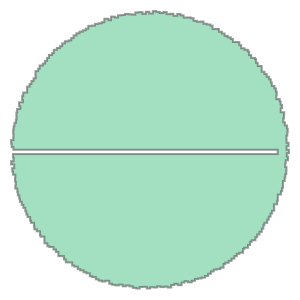

In [138]:
polygon

1540060480 True


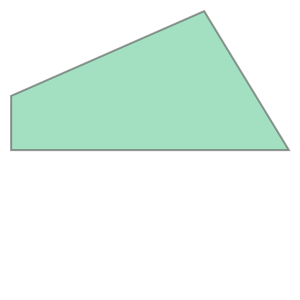

In [ ]:
for i in distances:
    d, a, b = i
    # d, (y1, x1), (y2, x2) = i

    # rectangle = Polygon([(y1, x1), (y1, x2), (y2, x2), (y2, x1)])

    rectangle = Polygon([(a[0], a[1]), (a[0], b[1]), (b[0], b[1]), (b[0], a[1])])

    if polygon.contains(rectangle):
        print(d, polygon.contains(rectangle))
        break
rectangle

In [110]:
horizontals, verticals = [], []
for i in range(len(tiles)-1):
    (a, b), (c, d) = tiles[i:i+2]
    (horizontals if a == c else verticals).append(((a, b), (c, d)))
# horizontals, verticals

In [69]:
lines = []
for i in range(len(tiles)-1):
    (a, b), (c, d) = tiles[i:i+2]
    lines.append(((a, b), (c, d)))

In [95]:
tree = AABBTree()
aabb1 = AABB([(0, 0), (0, 0)])
aabb2 = AABB([(-1, 1), (-1, 1)])
aabb3 = AABB([(4, 5), (2, 3)])
tree.add(aabb1, 'box 1')
tree.does_overlap(aabb1), tree.does_overlap(aabb2)

(False, True)

In [96]:
tree = AABBTree()
for i in range(len(tiles)-1):
    (a, b), (c, d) = tiles[i:i+2]
    y1, y2, x1, x2 = min(a, c), max(a, c), min(b, d), max(b, d)

    tree.add(AABB([(y1, y2), (x1, x2)]), str(i))

In [36]:
# https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
def ccw(A,B,C):
    return abs(C[0]-A[0]) * abs(B[1]-A[1]) > abs(B[0]-A[0]) * abs(C[1]-A[1])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [38]:
def intersects(s0,s1):
    dx0 = s0[1][0]-s0[0][0]
    dx1 = s1[1][0]-s1[0][0]
    dy0 = s0[1][1]-s0[0][1]
    dy1 = s1[1][1]-s1[0][1]
    p0 = dy1*(s1[1][0]-s0[0][0]) - dx1*(s1[1][1]-s0[0][1])
    p1 = dy1*(s1[1][0]-s0[1][0]) - dx1*(s1[1][1]-s0[1][1])
    p2 = dy0*(s0[1][0]-s1[0][0]) - dx0*(s0[1][1]-s1[0][1])
    p3 = dy0*(s0[1][0]-s1[1][0]) - dx0*(s0[1][1]-s1[1][1])
    return (p0*p1<=0) & (p2*p3<=0)

In [57]:
# Example for 2D line segment intersection (non-inclusive)
def check_strict_intersection(p1, p2, p3, p4):
    # p1=(x1,y1), p2=(x2,y2), p3=(x3,y3), p4=(x4,y4)
    # Calculate denominator (determinant)
    det = (p2[0] - p1[0]) * (p4[1] - p3[1]) - (p2[1] - p1[1]) * (p4[0] - p3[0])

    # Lines are parallel or collinear
    if abs(det) < 1e-9: # Using tolerance for floating point
        # Handle collinear case: check for open interval overlap (more complex, often omitted if parallel is enough)
        return False # For simplicity, parallel/collinear lines don't have a single strict point intersection

    # Calculate t and s using Cramer's rule (or similar)
    t_num = (p3[0] - p1[0]) * (p4[1] - p3[1]) - (p3[1] - p1[1]) * (p4[0] - p3[0])
    s_num = (p3[0] - p1[0]) * (p2[1] - p1[1]) - (p3[1] - p1[1]) * (p2[0] - p1[0])
    t = t_num / det
    s = s_num / det

    # Check if t and s are strictly between 0 and 1
    return 0 < t < 1 and 0 < s < 1

# Example Usage:
p1, p2 = (0, 0), (2, 2) # Line 1
p3, p4 = (0, 2), (2, 0) # Line 2 (intersects at (1,1))
print(f"Intersect (1,1): {check_strict_intersection(p1, p2, p3, p4)}") # True

p1, p2 = (0, 0), (1, 1) # Line 1
p3, p4 = (1, 1), (2, 0) # Line 2 (touch at (1,1) - excluded)
print(f"Intersect (1,1): {check_strict_intersection(p1, p2, p3, p4)}") # True


p1, p2 = (0, 0), (1, 1) # Line 1
p3, p4 = (1, 1), (0, 0) # Line 2 (touch at (1,1) - excluded)
print(f"Intersect (1,1): {check_strict_intersection(p1, p2, p3, p4)}") # True

Intersect (1,1): True
Intersect (1,1): False
Intersect (1,1): False


In [111]:
def area(a, b):
    l = abs(a[0]-b[0])+1
    w = abs(a[1]-b[1])+1
    return l*w

distances = sorted([
    (area(a, b), a, b) for a, b in itertools.combinations(tiles, 2)
])

In [100]:
c = 10
for i in reversed(distances):
    v, (a, b), (c, d), = i

    y1, y2, x1, x2 = min(a, c), max(a, c), min(b, d), max(b, d)
    box = AABB([(y1, y2), (x1, x2)])
    if not tree.does_overlap(box):
        print(v, (a, b), (c, d))

30 (11, 1) (2, 3)
24 (9, 7) (2, 5)
24 (9, 5) (2, 3)
21 (11, 1) (9, 7)
18 (7, 1) (2, 3)
18 (2, 5) (7, 3)
15 (11, 1) (9, 5)
15 (11, 1) (7, 3)
15 (7, 1) (9, 5)
9 (11, 7) (9, 5)
9 (9, 5) (7, 3)
8 (9, 5) (2, 5)
7 (11, 1) (11, 7)
6 (2, 3) (7, 3)
5 (7, 1) (11, 1)
3 (11, 7) (9, 7)
3 (9, 7) (9, 5)
3 (7, 1) (7, 3)
3 (2, 5) (2, 3)


In [101]:
c = 10
for i in reversed(distances):
    d, a, b, = i

    h1 = (a[0], a[1]), (a[0], b[1])
    h2 = (b[0], a[1]), (b[0], b[1])
    v1 = (a[0], a[1]), (b[0], a[1])
    v2 = (a[0], b[1]), (b[0], b[1])

    crosses = any([any([check_strict_intersection(*h1, x, y) for x, y, in verticals]),
    any([check_strict_intersection(*h2, x, y) for x, y, in verticals]),
    any([check_strict_intersection(*v1, x, y) for x, y, in horizontals]),
    any([check_strict_intersection(*v2, x, y) for x, y, in horizontals])])
    if not crosses:
        print(d, a, b)
        break


50 (11, 7) (2, 3)


In [121]:
c = 100
for i in reversed(distances):
    d, a, b, = i

    h1 = (a[0], a[1]), (a[0], b[1])
    h2 = (b[0], a[1]), (b[0], b[1])
    v1 = (a[0], a[1]), (b[0], a[1])
    v2 = (a[0], b[1]), (b[0], b[1])

    crosses = any([any([check_strict_intersection(*h1, x, y) for x, y, in verticals]),
    any([check_strict_intersection(*h2, x, y) for x, y, in verticals]),
    any([check_strict_intersection(*v1, x, y) for x, y, in horizontals]),
    any([check_strict_intersection(*v2, x, y) for x, y, in horizontals])])

    # overlaps = any([
    #     any([intersects(h1, (x, y)) for x, y in horizontals if (h1 != (x, y))]),
    #     any([intersects(h2, (x, y)) for x, y in horizontals if (h2 != (x, y))]),
    #     any([intersects(v1, (x, y)) for x, y in horizontals if (v1 != (x, y))]),
    #     any([intersects(v2, (x, y)) for x, y in horizontals if (v2 != (x, y))])
    # ])
    if not crosses:
        print(d, a, b, c)
        c -= 1
        if not c:
            break


2760619312 (18542, 13065) (98162, 47736) 100
2707085744 (20086, 13065) (98162, 47736) 99
2661570788 (18542, 13065) (98162, 46492) 98
2609957956 (20086, 13065) (98162, 46492) 97
2602690085 (1677, 46159) (80319, 13065) 96
2574559335 (1677, 46159) (79469, 13065) 95
2514452639 (1677, 45037) (80319, 13065) 94
2487275589 (1677, 45037) (79469, 13065) 93
2458340308 (18542, 13065) (97628, 44148) 92
2429966916 (45279, 1788) (98162, 47736) 91
2410346612 (20086, 13065) (97628, 44148) 90
2399883066 (2074, 43735) (80319, 13065) 89
2374414575 (46488, 1788) (98162, 47736) 88
2373812716 (2074, 43735) (79469, 13065) 87
2364179220 (45279, 1788) (98162, 46492) 86
2356792600 (18542, 13065) (97628, 42864) 85
2355153600 (18542, 13065) (97573, 42864) 84
2336186784 (52283, 98456) (1692, 52280) 83
2310781400 (20086, 13065) (97628, 42864) 82
2310130875 (46488, 1788) (98162, 46492) 81
2309142400 (20086, 13065) (97573, 42864) 80
2306379096 (2074, 42540) (80319, 13065) 79
2298096340 (2355, 42540) (80319, 13065) 78


In [71]:
for i in reversed(distances):
    d, a, b, = i
    if not any(intersect(a, b, x, y) for x, y in lines):
        print(d, a, b)
        # break 

35 (7, 1) (11, 7)
24 (9, 7) (2, 5)
24 (9, 5) (2, 3)
8 (9, 5) (2, 5)
6 (2, 3) (7, 3)
5 (7, 1) (11, 1)
3 (11, 7) (9, 7)


In [105]:
intersects(((0, 0), (2, 2)), ((0, 0), (2, 2)))

True

In [ ]:
for i in range(len(tiles)-1):
    y1, x1 = tiles[i]
    y2, x2 = tiles[i+1]
    arr[min(y1, y2):max(y1, y2)+1, min(x1, x2):max(x1, x2)+1] = '#'
    print(y1, x1, y2, x2)
# arr

7 1 11 1
11 1 11 7
11 7 9 7
9 7 9 5
9 5 2 5
2 5 2 3
2 3 7 3


In [66]:
np.savetxt('./data/output9.txt', arr, delimiter=" ", fmt="%s") 

In [44]:
distances

[(3, (2, 5), (2, 3)),
 (3, (7, 1), (7, 3)),
 (3, (9, 7), (9, 5)),
 (3, (11, 7), (9, 7)),
 (5, (7, 1), (11, 1)),
 (6, (2, 3), (7, 3)),
 (7, (11, 1), (11, 7)),
 (8, (9, 5), (2, 5)),
 (9, (9, 5), (7, 3)),
 (9, (11, 7), (9, 5)),
 (15, (7, 1), (9, 5)),
 (15, (9, 7), (7, 3)),
 (15, (11, 1), (7, 3)),
 (15, (11, 1), (9, 5)),
 (18, (2, 5), (7, 3)),
 (18, (7, 1), (2, 3)),
 (21, (7, 1), (9, 7)),
 (21, (11, 1), (9, 7)),
 (24, (9, 5), (2, 3)),
 (24, (9, 7), (2, 5)),
 (25, (11, 7), (7, 3)),
 (30, (7, 1), (2, 5)),
 (30, (11, 1), (2, 3)),
 (30, (11, 7), (2, 5)),
 (35, (7, 1), (11, 7)),
 (40, (9, 7), (2, 3)),
 (50, (11, 1), (2, 5)),
 (50, (11, 7), (2, 3))]

In [17]:
d, a, b = distances[-1]

l = abs(a[0]-b[0])+1
w = abs(a[1]-b[1])+1
l*w

4778352648

In [20]:
distances[-10:]

[(97656.34214427652, (87039, 81692), (14319, 16511)),
 (97669.15964110677, (88960, 79327), (13312, 17548)),
 (97686.40570724261, (86671, 82145), (14319, 16511)),
 (97698.59970337343, (81204, 87652), (20724, 10924)),
 (97724.7321050306, (87039, 81692), (13312, 17548)),
 (97727.71298357494, (84613, 84404), (14319, 16511)),
 (97742.30065329954, (84613, 84404), (13312, 17548)),
 (97746.17787923985, (86671, 82145), (13312, 17548)),
 (97813.39100552644, (84177, 84975), (14319, 16511)),
 (97817.42459296298, (84177, 84975), (13312, 17548))]

In [43]:
def day9():
    pass

day9()